# Customer and sales insurance data analysis
This project builds a user profile of an interested customer. 
It answers the question: who would be interested in an insurance and why? 
The data provided is a mixture of customer and sales data. 

### Project imports

In [67]:
from collections import defaultdict

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, plot_roc_curve, make_scorer, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM, SVC

import numpy as np 
from numpy import mean, quantile, where, random

from xgboost import XGBClassifier

from scipy.stats import zscore

## Preprocessing

The following questions need to be answered:

- Batch learning or online learning?<br> 
  **Batch learning.**
- Amount of data? Number of attributes? Data quality?<br> 
  **5821 data points, 86 attributes, dataquality:no missing or null values, duplicates yes, no eroneous values, normalisation because of attributes with large absolute ranges needed**
- Class ratio? Balanced or there are rare classes? Is the class ratio representative(for the new fresh data)?<br>
  **The classes are very unbalanced. We have 4879 people that don't have insurance (0) and only 340 people that have bought an insurance (1). We could say that the positive class is (more) rare.**
- Who has labeled the target data? Will it represent the incoming data?<br>
  **The data is from existing clients, so it should represent the incoming data well.**
- Is the marginal distribution p(x) of the training data equal to the fresh data?<br> 
  **This we cannot know for sure, but we can asume that it will be, as the data is a subset of the data that the insurance works with every day.**
- How recent is the data? Should we account for changing processes over time?<br>
  **N/A. If something changes in the way data collection is made or saved by the insurance, we would have to change the setup.**
- Multiple data sources? How is each source’s credibility, quality and consistency?<br> 
  **Just one source, no way to check.**
- Is there a fixed given data set, or a data collection protocol needs to be developed?<br> 
  **It is a fixed given dataset.**
- Data dependencies: data might contain independent observations, sequences or interdependent data.<br>
  **I explored this with the scatter matrix and the principal component analysis**

Preprocessing actions (see implementations in their respective sections below):

- Solve data conflicts (things like different unit measurements) ✅ **(not necessary)**
- Check and remove duplicates ✅
- Transform categorical data to numeric if necessary ✅ **(already done)**
- Check for large absolute ranges of the attributes - if they are present perform feature normalisation ✅
- Feature construction: should some features be merged or mapped to allow more complex decisions? ❌
- Handle missing values ✅
- Handle erroneous values ✅
- Perform feature selection if necessary for dimensionality reduction ✅

In [2]:
df = pd.read_csv("data/caravan.train", delimiter="\t")
df.columns = range(1, 87)
df

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,82,83,84,85,86
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
3,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
4,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5817,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5818,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5819,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


### Creating dictionaries with the data descriptions and labels to use for better understand and visualisaion

In [3]:
data = []

#Read the data infomation from the file
with open("data/caravan.info", "r", encoding="unicode_escape") as f:
    lines = [line.split() for line in f.readlines()]
    for i, line in enumerate(lines): 
        if line == [] and lines[i-1] == []:
            data.append(lines[2:i-1]) if not data else data.append(lines[checkpoint:i-1])
            checkpoint = i+1    

#Package data
def return_value_dict(keys, values):
    d = defaultdict(dict)
    for i, v in enumerate(values, start=1):
        for j, k in enumerate(keys):
            d[i].update({k:v[j+1]}) if j==0 else d[i].update({k:" ".join(v[2:])})
    return d

#Create comprehensive dicts to use with visualisation
add_keys = [data[1][2][1]]

data_dict = return_value_dict(data[0][0][1:3], data[0][2:])
L0 = return_value_dict(add_keys, data[1][3:])
L1 = return_value_dict(add_keys, data[2][2:])
L3 = return_value_dict(add_keys, data[3][2:])

In [4]:
df.columns = [data_dict.get(i, {}).get('Name') for i in range (1, 87)]

df.head(5)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
3,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
4,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0


### Missing values 

In [5]:
df.isnull().values.any()
#There aren't any missing values in the data

False

### Duplicates

At first, after discovering that the dataset has duplicates, I removed them. Then, giving it another thought, I realised that each row represent a different lead/customer, and that if multiple of those customers are the same, that isn't less information it is more. So I decided to keep the duplicates. Indeed, the models performed a tiny bit better with the duplicates in. 

In [6]:
df.duplicated().value_counts()
#There seem to be 602 duplicated items in the data. 

False    5219
True      602
dtype: int64

In [7]:
if (duplicated := df.duplicated(keep=False)).any():
    some_duplicates = df[duplicated].sort_values(by=df.columns.to_list()).head()
    print(f"Dataframe has one or more duplicated rows, for example:\n{some_duplicates}")

Dataframe has one or more duplicated rows, for example:
      MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
2057        1         1        2         4         1       0       2       0   
5699        1         1        2         4         1       0       2       0   
3524        1         1        2         4         1       0       2       0   
3942        1         1        2         4         1       0       2       0   
983         1         1        2         4         1       0       4       0   

      MGODGE  MRELGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  \
2057       7       6  ...         0        0        0       0        0   
5699       7       6  ...         0        0        0       0        0   
3524       7       6  ...         0        0        0       1        0   
3942       7       6  ...         0        0        0       1        0   
983        5       7  ...         0        0        0       0        0   

      APLEZIER  AF

In [8]:
#df.drop_duplicates(subset=None, keep="first", inplace=True)

In [9]:
df.duplicated().value_counts()
#All duplicates are removed

False    5219
True      602
dtype: int64

### Erouneous values 

We've been given a dataset that has already been transformed into numerical values. To check for consistency and if that is really so, we can look at all the data.

**I checked min and max of the attributes and the distributions to verify the ranges. I realised that I don't know enough about the domain, and why for example there are multiple values for "Married" like shown below, when I would expect it to be a boolean value. Withough other further information about the data, and nothing that seems very out of place, I have decided to accept it as it is.**

In [10]:
df.dtypes.value_counts()
#All dtypes are indeed numerical! 

int64    86
dtype: int64

In [11]:
#Converting the names of the columns to their description to better understand the values shown
df.columns = [data_dict.get(i, {}).get('Description') for i in range (1, 87)]

#Checking for numbers outside of the range
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.describe().loc[['min','max']])

     Customer Subtype see L0  Number of houses 1  10  \
min                      1.0                      1.0   
max                     41.0                     10.0   

     Avg size household 1  6  Avg age see L1  Customer main type see L2  \
min                       1.0             1.0                        1.0   
max                       5.0             6.0                       10.0   

     Roman catholic see L3  Protestant ...  Other religion  No religion  \
min                    0.0             0.0             0.0          0.0   
max                    9.0             9.0             5.0          9.0   

     Married  Living together  Other relation  Singles  \
min      0.0              0.0             0.0      0.0   
max      9.0              7.0             9.0      9.0   

     Household without children  Household with children  \
min                         0.0                      0.0   
max                         9.0                      9.0   

     High level e

<AxesSubplot: ylabel='Density'>

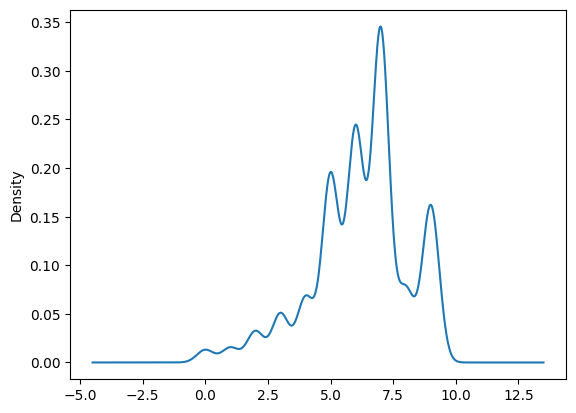

In [12]:
df['Married'].plot(kind='kde')

### Separating the target class after cleanup

In [13]:
df.columns = [data_dict.get(i, {}).get('Name') for i in range (1, 87)]

df_target = df['CARAVAN']
df = df.drop(['CARAVAN'], axis=1)

df_target.value_counts()

0    5473
1     348
Name: CARAVAN, dtype: int64

### Feature normalisation

When exploring the values, we can notice that the first colum "MOSTYPE" has a range that is way larger than any of the other attributes. While every other attribute is moving between the 0-10 range maximum, we have th first one moving all the way to 41. This will dispropotionally highlight this attribute in the learning algorithms. 

Initally, I thought I need to perform feature normalisation to get more balanced and better results. On second thought and after some poking around, I realised that the 41 isn't a continuous value, it is just a label. So normalising everything and scaling it to that label didn't really help me enough to get the right results.

So I decided to one-hot encode the "real" categorical labels, which are the L0 and L2.

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.describe().loc[['min','max']])

     MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
min      1.0       1.0      1.0       1.0       1.0     0.0     0.0     0.0   
max     41.0      10.0      5.0       6.0      10.0     9.0     9.0     5.0   

     MGODGE  MRELGE  MRELSA  MRELOV  MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  \
min     0.0     0.0     0.0     0.0       0.0       0.0       0.0       0.0   
max     9.0     9.0     7.0     9.0       9.0       9.0       9.0       9.0   

     MOPLMIDD  MOPLLAAG  MBERHOOG  MBERZELF  MBERBOER  MBERMIDD  MBERARBG  \
min       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
max       9.0       9.0       9.0       5.0       9.0       9.0       9.0   

     MBERARBO  MSKA  MSKB1  MSKB2  MSKC  MSKD  MHHUUR  MHKOOP  MAUT1  MAUT2  \
min       0.0   0.0    0.0    0.0   0.0   0.0     0.0     0.0    0.0    0.0   
max       9.0   9.0    9.0    9.0   9.0   9.0     9.0     9.0    9.0    7.0   

     MAUT0  MZFONDS  MZPART  MINKM30  MINK3045  MINK45

In [15]:
one_hot_df = pd.get_dummies(df, columns=['MOSTYPE', 'MOSHOOFD'])
one_hot_df

,MAANTHUI,MGEMOMV,MGEMLEEF,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,...,MOSHOOFD_1,MOSHOOFD_2,MOSHOOFD_3,MOSHOOFD_4,MOSHOOFD_5,MOSHOOFD_6,MOSHOOFD_7,MOSHOOFD_8,MOSHOOFD_9,MOSHOOFD_10
0,1,2,2,1,4,1,4,6,2,2,...,0,0,0,0,0,0,0,1,0,0
1,1,2,2,0,4,2,4,3,2,4,...,0,0,0,0,0,0,0,1,0,0
2,1,3,3,2,3,2,4,5,2,2,...,0,0,1,0,0,0,0,0,0,0
3,1,4,2,1,4,1,4,7,1,2,...,0,0,0,0,0,0,0,0,0,1
4,1,2,1,0,5,0,5,0,6,3,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,1,1,2,0,6,1,2,1,2,6,...,0,0,0,0,0,0,0,1,0,0
5817,1,4,4,1,4,1,4,6,0,3,...,0,0,0,0,0,0,0,1,0,0
5818,1,3,4,0,6,0,3,5,1,4,...,0,0,0,0,0,0,0,1,0,0
5819,1,3,2,0,7,0,2,7,2,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
scaler = MinMaxScaler()
df_normal = scaler.fit_transform(one_hot_df) 
#df_normal = one_hot_df.apply(zscore)
df_normal

array([[0.  , 0.25, 0.2 , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.25, 0.2 , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.4 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.5 , 0.6 , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.2 , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.4 , ..., 1.  , 0.  , 0.  ]])

### Data dependencies and dimensionality reduction

With such a large number of attributes, it is very difficult to explore the dependencies between every column. As a proof, there is this unreadable scatter matrix for the whole dataset. It would be possible to explore dependencies for individual caes, but we would have to either pick random columns, or we could try to apply dimensionality reduction. It would be also beneficial to explore if this is possible, as we have 86 attributes. 

array([[<AxesSubplot: xlabel='MOSTYPE', ylabel='MOSTYPE'>,
        <AxesSubplot: xlabel='MAANTHUI', ylabel='MOSTYPE'>,
        <AxesSubplot: xlabel='MGEMOMV', ylabel='MOSTYPE'>, ...,
        <AxesSubplot: xlabel='AFIETS', ylabel='MOSTYPE'>,
        <AxesSubplot: xlabel='AINBOED', ylabel='MOSTYPE'>,
        <AxesSubplot: xlabel='ABYSTAND', ylabel='MOSTYPE'>],
       [<AxesSubplot: xlabel='MOSTYPE', ylabel='MAANTHUI'>,
        <AxesSubplot: xlabel='MAANTHUI', ylabel='MAANTHUI'>,
        <AxesSubplot: xlabel='MGEMOMV', ylabel='MAANTHUI'>, ...,
        <AxesSubplot: xlabel='AFIETS', ylabel='MAANTHUI'>,
        <AxesSubplot: xlabel='AINBOED', ylabel='MAANTHUI'>,
        <AxesSubplot: xlabel='ABYSTAND', ylabel='MAANTHUI'>],
       [<AxesSubplot: xlabel='MOSTYPE', ylabel='MGEMOMV'>,
        <AxesSubplot: xlabel='MAANTHUI', ylabel='MGEMOMV'>,
        <AxesSubplot: xlabel='MGEMOMV', ylabel='MGEMOMV'>, ...,
        <AxesSubplot: xlabel='AFIETS', ylabel='MGEMOMV'>,
        <AxesSubplot: xlabel='A

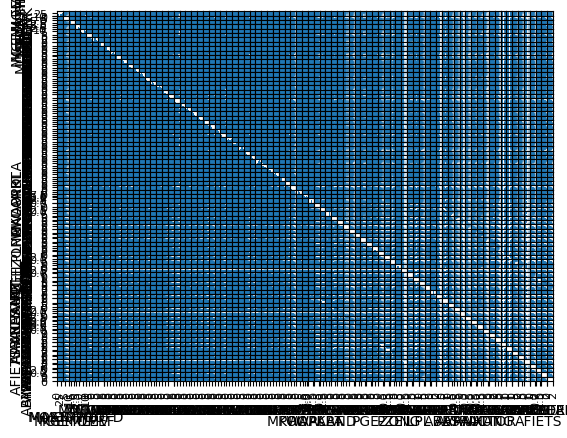

In [17]:
pd.plotting.scatter_matrix(df, alpha=0.2)

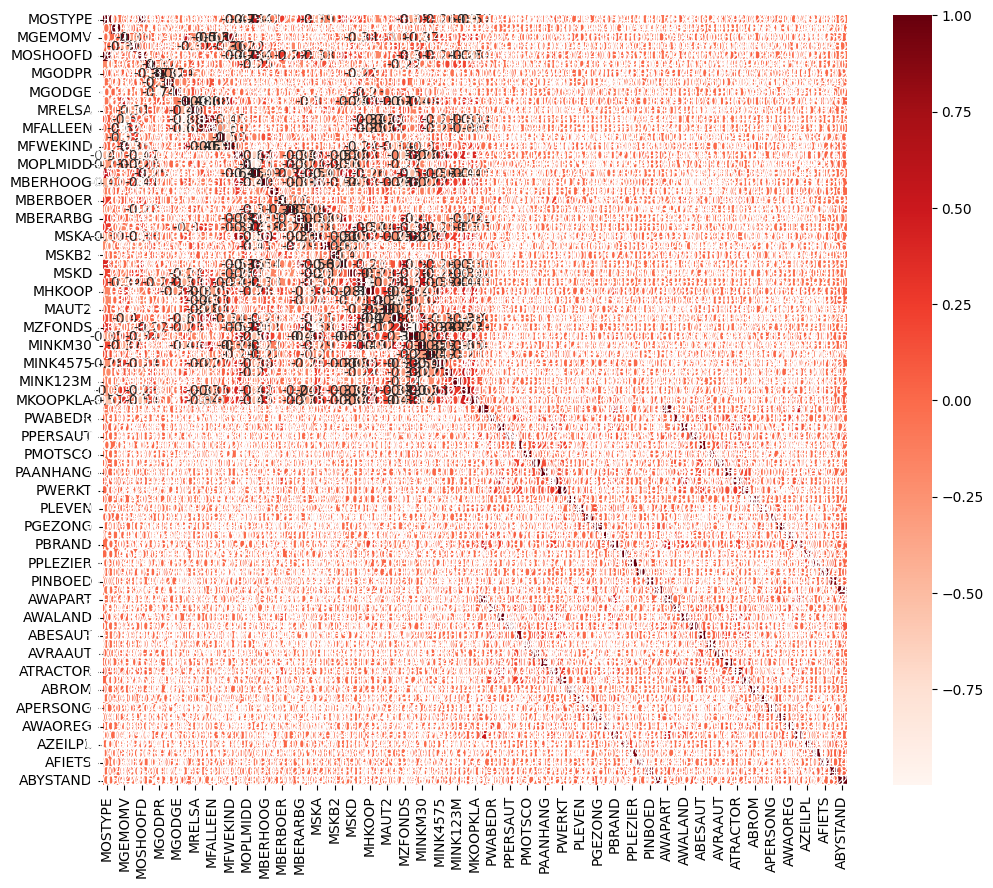

In [18]:
#Pearson correlation heatmap
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

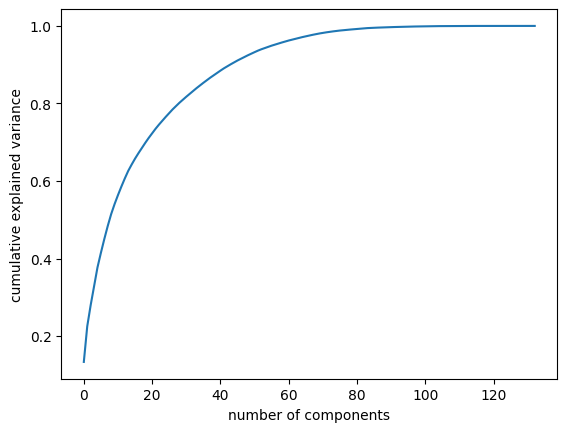

In [19]:
pca = PCA().fit(df_normal)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We can see that the first 20 componenets contain the most of variance, and we need about 60 to achieve almost 100%.
This means that with about 30 we would be able to capture above 90% of the variance. This will reduce our dimensionality from 86 to 30 which is a considerable amount. 

In [20]:
pca = PCA(30)  # project from 133 to 30 dimensions
df_pca = pca.fit_transform(df_normal)
print(df_normal.shape)
print(df_pca.shape)
df_pca

(5821, 133)
(5821, 30)


array([[-0.17981691,  0.53811949, -0.37646153, ...,  0.00339412,
        -0.05627206,  0.15473352],
       [ 0.67937778,  0.2225461 , -0.43294707, ...,  0.16129589,
        -0.10038549,  0.47881832],
       [-0.27361584, -0.50024473,  0.47699116, ..., -0.1428404 ,
         0.01648713,  0.20274761],
       ...,
       [ 0.92033152,  0.8890153 , -0.40455093, ..., -0.06420227,
        -0.17724874,  0.11720925],
       [-0.1200926 ,  1.03715755,  0.24812135, ..., -0.02222905,
         0.07338448,  0.1061588 ],
       [ 0.38216153,  1.03094413, -0.21781946, ...,  0.01398063,
        -0.12207092, -0.01521123]])

## Test data preprocessing

In [99]:
#Import test data
df_test = pd.read_csv("data/caravan.test", delimiter="\t")
df_test.columns = [data_dict.get(i, {}).get('Name') for i in range (1, 86)]

#Clean up data
print("There aren't any missing values in the data, test:", df_test.isnull().values.any())

#Save both normalised and non-normalised version
one_hot_df_test = pd.get_dummies(df_test, columns=['MOSTYPE', 'MOSHOOFD'])
df_test_normal = scaler.fit_transform(one_hot_df_test) 
df_test_normal

There aren't any missing values in the data, test: False


array([[0. , 0.4, 0.2, ..., 0. , 0. , 0. ],
       [0. , 0.4, 0.4, ..., 0. , 1. , 0. ],
       [0. , 0.2, 0.4, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0.2, 0.4, ..., 1. , 0. , 0. ],
       [0. , 0.4, 0.4, ..., 1. , 0. , 0. ],
       [0. , 0.2, 0.4, ..., 0. , 0. , 0. ]])

## Models: difffernt approaches when dealint with a very unbalanced dataset

### One-class SVM

The anomaly detection approach is not giving the expected results, and doesn't seem to work for this particular use case. I also tried IsolationForest with the same results.

In [22]:
#one-class svm for imbalanced binary classification
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.02)
pred = svm.fit_predict(df_normal)
scores = svm.score_samples(df_normal)

thresh = quantile(scores, 0.03)
print(thresh)

index = where(scores<=thresh)
values = df_normal[index]

values

df_target.loc[df_target.index[index]].value_counts()

105.25266864816027


0    166
1      9
Name: CARAVAN, dtype: int64

### Bagging with undersampling

In [75]:
# bagged decision trees wity roc auc evaluation
model = BaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.650


In [70]:
# bagged decision trees with f2 evaluation
model = BaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.085


In [76]:
# bagged decision trees with random undersampling and roc auc evaluation
model = BalancedBaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.722


In [71]:
# bagged decision trees with random undersampling and f2 evaluation 
model = BalancedBaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.320


### Random forest with class weighting

In [77]:
# random forest with roc_auc evaluation
model = RandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.637


In [72]:
# random forest with f2 evaluation
model = RandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.068


In [78]:
# random forest with random undersampling and roc_auc evaluation
model = BalancedRandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.704


In [73]:
# random forest with random undersampling and f2 evaluation
model = BalancedRandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, one_hot_df, df_target, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.316


### XGBoost

In [37]:
def report_all_configurations(grid_result):
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [79]:
#XGBoost with roc auc evaluation
model = XGBClassifier()

weights = [1, 10, 15, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(one_hot_df, df_target)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report_all_configurations(grid_result)

Best: 0.722754 using {'scale_pos_weight': 1}
0.722754 (0.040209) with: {'scale_pos_weight': 1}
0.706122 (0.036316) with: {'scale_pos_weight': 10}
0.701813 (0.039123) with: {'scale_pos_weight': 15}
0.703211 (0.035422) with: {'scale_pos_weight': 25}
0.698049 (0.039129) with: {'scale_pos_weight': 50}
0.693493 (0.037224) with: {'scale_pos_weight': 75}
0.696543 (0.037587) with: {'scale_pos_weight': 99}
0.692597 (0.035940) with: {'scale_pos_weight': 100}
0.689304 (0.038088) with: {'scale_pos_weight': 1000}


In [74]:
#XGBoost with f2 evaluation
model = XGBClassifier()

weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=make_scorer(fbeta_score, beta=2))
grid_result = grid.fit(one_hot_df, df_target)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report_all_configurations(grid_result)

Best: 0.267575 using {'scale_pos_weight': 1000}
0.071312 (0.042989) with: {'scale_pos_weight': 1}
0.173929 (0.058964) with: {'scale_pos_weight': 10}
0.212416 (0.058960) with: {'scale_pos_weight': 25}
0.231307 (0.057985) with: {'scale_pos_weight': 50}
0.223857 (0.052838) with: {'scale_pos_weight': 75}
0.250389 (0.054450) with: {'scale_pos_weight': 99}
0.250996 (0.060404) with: {'scale_pos_weight': 100}
0.267575 (0.051396) with: {'scale_pos_weight': 1000}


**Unexpected: once the metric is changed, the weighting starts to actually show impact. Same for some other models.**

### Grid search weighted logistic regression

In [30]:
#logistic regression model with roc auc evaluation

model = LogisticRegression(solver='liblinear', fit_intercept=True)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, df_normal, df_target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.738


In [80]:
#logistic regression model with f2 evaluation

model = LogisticRegression(solver='liblinear', fit_intercept=True)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, df_normal, df_target, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.009


In [46]:
# grid search class weights with logistic regression and roc auc evaluation

model = LogisticRegression(solver='liblinear', fit_intercept=True)
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(df_normal, df_target)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report_all_configurations(grid_result)

Best: 0.738479 using {'class_weight': {0: 1, 1: 1}}
0.736461 (0.034601) with: {'class_weight': {0: 100, 1: 1}}
0.737211 (0.034699) with: {'class_weight': {0: 10, 1: 1}}
0.738479 (0.034430) with: {'class_weight': {0: 1, 1: 1}}
0.732043 (0.033423) with: {'class_weight': {0: 1, 1: 10}}
0.721161 (0.033756) with: {'class_weight': {0: 1, 1: 100}}


In [81]:
# grid search class weights with logistic regression and f2 evaluation

model = LogisticRegression(solver='liblinear', fit_intercept=True)
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=make_scorer(fbeta_score, beta=2))
grid_result = grid.fit(df_normal, df_target)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report_all_configurations(grid_result)

Best: 0.326943 using {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.009449 (0.018118) with: {'class_weight': {0: 1, 1: 1}}
0.326943 (0.048989) with: {'class_weight': {0: 1, 1: 10}}
0.287894 (0.010512) with: {'class_weight': {0: 1, 1: 100}}


### Grid search weighted SVM

In [34]:
# svm with roc auc evaluation

model = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, df_normal, df_target, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.645


In [84]:
# svm with f2 evaluation

model = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, df_normal, df_target, scoring=make_scorer(fbeta_score, beta=2), cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.000


In [50]:
# svm with weighted grid search and roc auc evaluation

model = SVC()
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
C = [0.1,1, 10, 100]
gamma = [1,0.1,0.01,0.001]
kernel = ['rbf', 'poly', 'sigmoid']
param_grid = dict(class_weight=balance, C=C, gamma=gamma, kernel=kernel)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(df_normal, df_target)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report_all_configurations(grid_result)

Best: 0.743879 using {'C': 1, 'class_weight': {0: 1, 1: 10}, 'gamma': 0.01, 'kernel': 'rbf'}
0.591989 (0.040603) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 1, 'kernel': 'rbf'}
0.626201 (0.039500) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 1, 'kernel': 'poly'}
0.563717 (0.080622) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 1, 'kernel': 'sigmoid'}
0.638492 (0.045646) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.1, 'kernel': 'rbf'}
0.629093 (0.049108) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.1, 'kernel': 'poly'}
0.584764 (0.052849) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.575161 (0.065787) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.01, 'kernel': 'rbf'}
0.573458 (0.074722) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.01, 'kernel': 'poly'}
0.547792 (0.073221) with: {'C': 0.1, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.01, 'kernel': 'sigmo

In [87]:
# svm with weighted grid search

model = SVC()
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
C = [0.01, 0.1, 1, 10, 100]
gamma = [1, 0.1, 0.01, 0.001]
kernel = ['rbf', 'poly', 'sigmoid']
param_grid = dict(class_weight=balance, C=C, gamma=gamma, kernel=kernel)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=make_scorer(fbeta_score, beta=2))
grid_result = grid.fit(df_normal, df_target)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
report_all_configurations(grid_result)

Best: 0.343408 using {'C': 1, 'class_weight': {0: 1, 1: 10}, 'gamma': 0.01, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 1, 'kernel': 'rbf'}
0.023236 (0.027299) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 1, 'kernel': 'poly'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 1, 'kernel': 'sigmoid'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.1, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.1, 'kernel': 'poly'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.01, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.01, 'kernel': 'poly'}
0.000000 (0.000000) with: {'C': 0.01, 'class_weight': {0: 100, 1: 1}, 'gamma': 0.01, 'kernel

## Best model predictions and explorations

In [91]:
from numpy import mean

best_model_roc_auc = SVC(C=1, class_weight={0: 1, 1: 10}, gamma=0.01, kernel='rbf')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(best_model_roc_auc, df_normal, df_target, scoring='roc_auc', 
                         cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.744


In [92]:
from numpy import mean

best_model_f2 = SVC(C=1, class_weight={0: 1, 1: 10}, gamma=0.01, kernel='rbf')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(best_model_f2, df_normal, df_target, scoring=make_scorer(fbeta_score, beta=2), 
                         cv=cv, n_jobs=-1)

print('Mean F2: %.3f' % mean(scores))

Mean F2: 0.343


## Answering the question: which customers and why? 

In [100]:
best_model = SVC(C=1, class_weight={0: 1, 1: 10}, gamma=0.01, kernel='rbf')
best_model.fit(df_normal, df_target)

#Predict the response for test dataset
y_pred = best_model.predict(df_test_normal)

In [101]:
from collections import Counter

print(Counter(y_pred))

df_test_normal[np.where(y_pred == 1)]

Counter({1: 603, 0: 3396})

In [105]:
from sklearn.inspection import permutation_importance
%matplotlib inline

perm_importance = permutation_importance(best_model, df_test_normal, y_pred)
sorted_idx = perm_importance.importances_mean.argsort()

IndexError: index 97 is out of bounds for axis 0 with size 85

Text(0.5, 0, 'Permutation Importance')

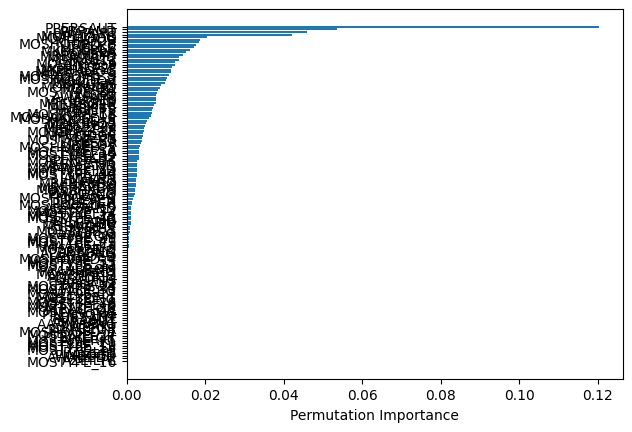

In [119]:
features = np.array(one_hot_df_test.columns)

plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

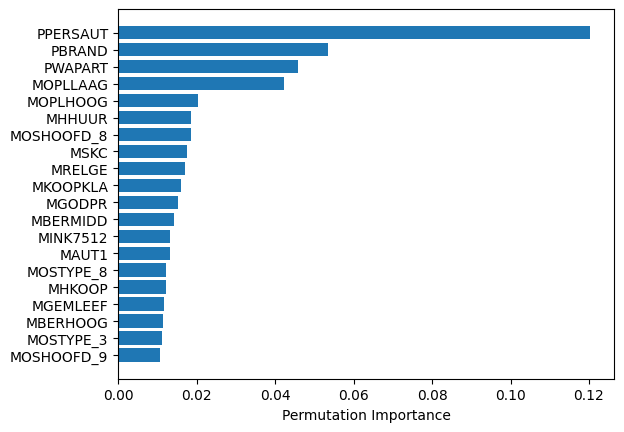

In [120]:
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Permutation Importance")